In [2]:
pip install scikit-learn-extra

     ---------------------------------------- 0.0/340.5 kB ? eta -:--:--
     - -------------------------------------- 10.2/340.5 kB ? eta -:--:--
     --- --------------------------------- 30.7/340.5 kB 262.6 kB/s eta 0:00:02
     ---- -------------------------------- 41.0/340.5 kB 279.3 kB/s eta 0:00:02
     ---------- -------------------------- 92.2/340.5 kB 476.3 kB/s eta 0:00:01
     ---------------------------- --------- 256.0/340.5 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 340.5/340.5 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.

In [1]:
from collections.abc import Iterable
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import KMedoids
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate

In [2]:
# Mendefinisikan path dataset
dataset_path = r"C:\Users\alvia\Downloads\mfds_data"

# Inisialisasi list untuk menyimpan data gambar dan label
data = []
labels = []

# Mengambil list folder di dalam dataset
folders = os.listdir(dataset_path)

# Looping untuk membaca setiap folder dan gambar di dalamnya
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue  # Skip non-directories
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        if not image_path.endswith(('.jpg', '.jpeg', '.png')):  # Skip non-image files
            continue
        image = load_img(image_path, target_size=(64, 64))
        image_array = img_to_array(image)
        data.append(image_array)
        labels.append(folder)

# Mengubah data dan label menjadi array numpy
data = np.array(data)
labels = np.array(labels)

In [3]:
# Mengubah label menjadi nilai numerik
label_mapping = {label: index for index, label in enumerate(np.unique(labels))}
encoded_labels = np.array([label_mapping[label] for label in labels])

In [4]:
# Melakukan split dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

In [5]:
# Normalisasi data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
# Perform K-Medoids clustering
n_clusters = len(label_mapping)
kmedoids = KMedoids(n_clusters=n_clusters, metric='euclidean', random_state=42)
cluster_labels = kmedoids.fit_predict(X_train.reshape(X_train.shape[0], -1))

In [7]:
# Membangun model CNN
image_input = Input(shape=(64, 64, 3), name='image_input')
cluster_label_input = Input(shape=(1,), name='cluster_label_input')

# Define CNN layers
conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(maxpool2)
dense1 = Dense(64, activation='relu')(flatten)

# Merge image features and cluster labels
merged = Concatenate()([dense1, cluster_label_input])

# Add classification layers
dense2 = Dense(n_clusters + len(label_mapping), activation='relu')(merged)
output = Dense(len(label_mapping), activation='softmax')(dense2)

In [8]:
# Create the model
model = Model(inputs=[image_input, cluster_label_input], outputs=output)

In [9]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train model
history = model.fit([X_train, cluster_labels], y_train, epochs=10, batch_size=32, validation_data=([X_test, kmedoids.predict(X_test.reshape(X_test.shape[0], -1))], y_test))

y_pred = model.predict([X_test, kmedoids.predict(X_test.reshape(X_test.shape[0], -1))])
y_pred_classes = np.argmax(y_pred, axis=1)

Epoch 1/10
100/100 [==============================] - 19s 170ms/step - loss: 1.8864 - accuracy: 0.2366 - val_loss: 1.6241 - val_accuracy: 0.3162
Epoch 2/10
100/100 [==============================] - 17s 170ms/step - loss: 1.2823 - accuracy: 0.5016 - val_loss: 1.0039 - val_accuracy: 0.6037
Epoch 3/10
100/100 [==============================] - 17s 168ms/step - loss: 0.7409 - accuracy: 0.7297 - val_loss: 0.6251 - val_accuracy: 0.8025
Epoch 4/10
100/100 [==============================] - 17s 168ms/step - loss: 0.5606 - accuracy: 0.8009 - val_loss: 0.5232 - val_accuracy: 0.7925
Epoch 5/10
100/100 [==============================] - 18s 177ms/step - loss: 0.3448 - accuracy: 0.8825 - val_loss: 0.4116 - val_accuracy: 0.8650
Epoch 6/10
100/100 [==============================] - 17s 175ms/step - loss: 0.2806 - accuracy: 0.9109 - val_loss: 0.3818 - val_accuracy: 0.8637
Epoch 7/10
100/100 [==============================] - 17s 169ms/step - loss: 0.2110 - accuracy: 0.9328 - val_loss: 0.3386 - val_ac

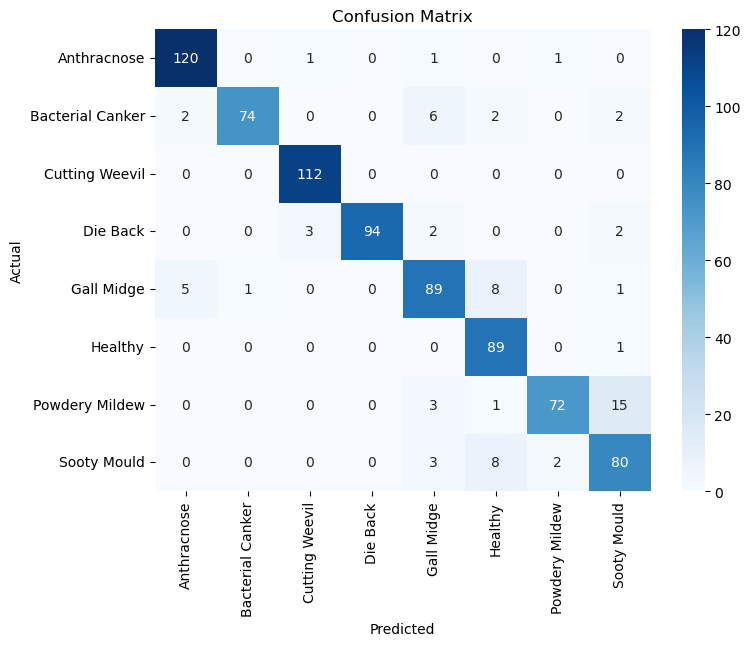

                  precision    recall  f1-score   support

     Anthracnose       0.94      0.98      0.96       123
Bacterial Canker       0.99      0.86      0.92        86
  Cutting Weevil       0.97      1.00      0.98       112
        Die Back       1.00      0.93      0.96       101
      Gall Midge       0.86      0.86      0.86       104
         Healthy       0.82      0.99      0.90        90
  Powdery Mildew       0.96      0.79      0.87        91
     Sooty Mould       0.79      0.86      0.82        93

        accuracy                           0.91       800
       macro avg       0.92      0.91      0.91       800
    weighted avg       0.92      0.91      0.91       800



In [11]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualisasi confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

classification_result = classification_report(y_test, y_pred_classes, target_names=label_mapping.keys())
print(classification_result)

In [12]:
#Tambahkan Grafik Precision dan Recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred_classes, average=None)
recall = recall_score(y_test, y_pred_classes, average=None)

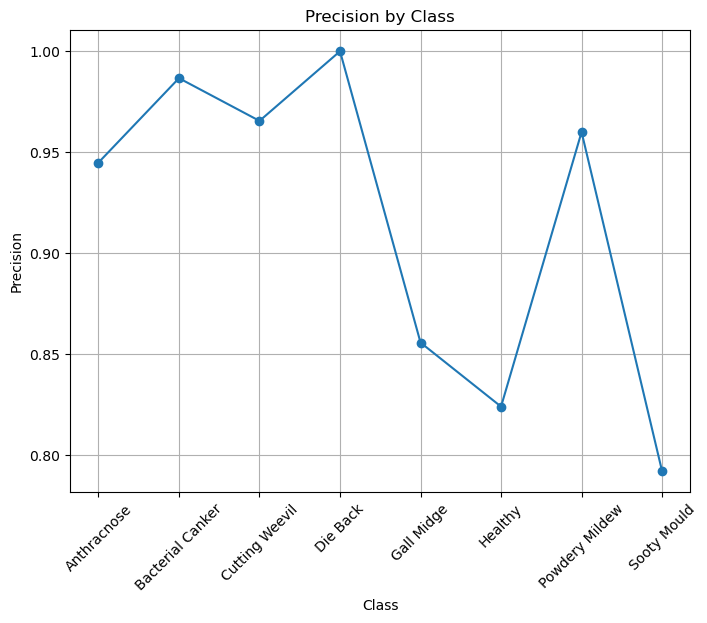

In [13]:
# Buat grafik Precision sebagai line chart
plt.figure(figsize=(8, 6))
plt.plot(label_mapping.keys(), precision, marker='o', linestyle='-')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision by Class')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.grid(True)  # Add grid lines
plt.show()

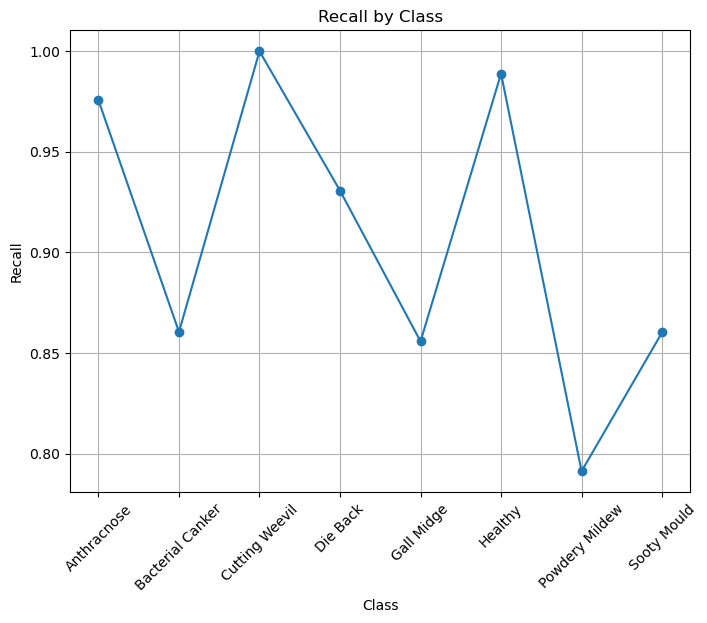

In [14]:
# Buat grafik Recall sebagai line chart
plt.figure(figsize=(8, 6))
plt.plot(label_mapping.keys(), recall, marker='o', linestyle='-')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall by Class')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.grid(True)  # Add grid lines
plt.show()

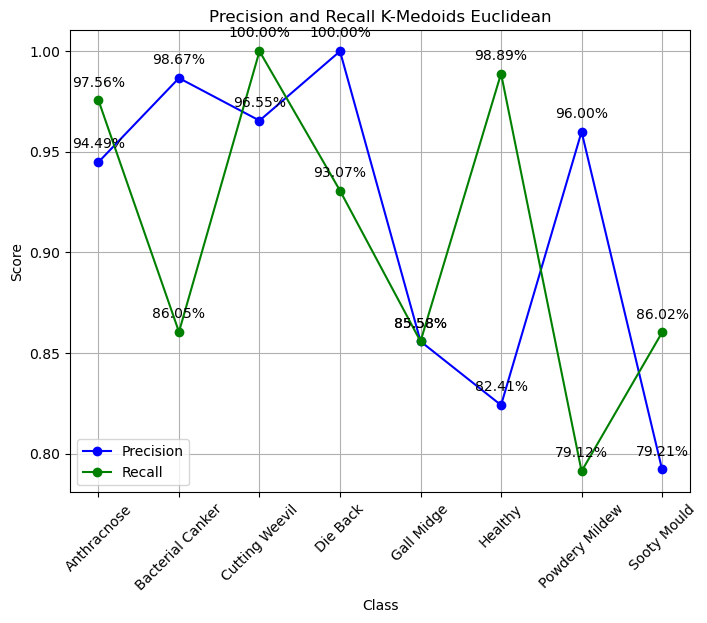

In [15]:
# Create a figure and axis
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot Precision as a blue line
precision_line, = ax.plot(label_mapping.keys(), precision, marker='o', linestyle='-', color='blue', label='Precision')

# Plot Recall as a red line
recall_line, = ax.plot(label_mapping.keys(), recall, marker='o', linestyle='-', color='green', label='Recall')

# Set labels and title
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision and Recall K-Medoids Euclidean')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Add grid lines
plt.grid(True)

# Add a legend to distinguish Precision and Recall
plt.legend(loc='lower left')

# Annotate the points with their values (percentages)
for x, y in zip(label_mapping.keys(), precision):
    ax.annotate(f'{y*100:.2f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

for x, y in zip(label_mapping.keys(), recall):
    ax.annotate(f'{y*100:.2f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.show()